In [21]:
import numpy as np
from random import sample, uniform, normalvariate
from  matplotlib.pyplot import plot, scatter
%matplotlib inline

In [36]:
def generate_data(img_size, line_params, n_points, sigma, inlier_ratio):
    w, h = img_size
    A, B, C = line_params
    line_n_points = int(n_points * inlier_ratio + 0.5)
    x_borders = sorted([(-B*0-C)/A,(-B*h-C)/A])
    left_border = min(max(x_borders[0], 0), w)
    right_border = max(min(x_borders[1], w), 0)
    x_line = []
    y_line = []
    if left_border != right_border:
        x_line = [uniform(left_border, right_border) for i in range(line_n_points)]
        y_line = [-1*(A*x+C)/B+normalvariate(0,sigma) for x in x_line]
    x_uniform = [uniform(0,w) for i in range(n_points - line_n_points)]
    y_uniform = [uniform(0,h) for i in range(n_points - line_n_points)]
    x = x_line + x_uniform
    y = y_line + y_uniform
    points = [[_x, _y] for _x,_y in zip(x,y) if (0<=_x<=w and 0<=_y<=h)]
    return np.array(points)

In [37]:
data = generate_data((500, 300), (-2, 1, -20), 500, 10, 0.5)

In [38]:
data.shape

(494, 2)

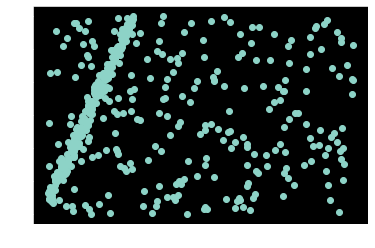

In [39]:
scatter(data[:,0], data[:,1])

In [29]:
data = generate_data((500, 300), (-2, 1, -20), 500, 10, 0.5)

In [30]:
data.shape

(324, 2)

In [33]:
np.array([])

array([], dtype=float64)

In [40]:
from scipy.stats import chi2

In [54]:
chi2.ppf(0.95, 1)

3.841458820694124

In [103]:
import numpy as np
from math import log
from random import sample, uniform, normalvariate
from scipy.stats import chi2


def generate_data(img_size, line_params, n_points, sigma, inlier_ratio):
    w, h = img_size
    A, B, C = line_params
    line_n_points = int(n_points * inlier_ratio + 0.5)
    x_borders = sorted([(-B*0-C)/A,(-B*h-C)/A])
    left_border = min(max(x_borders[0], 0), w)
    right_border = max(min(x_borders[1], w), 0)
    x_line = []
    y_line = []
    if left_border != right_border:
        x_line = [uniform(left_border, right_border) for i in range(line_n_points)]
        y_line = [-1*(A*x+C)/B+normalvariate(0,sigma) for x in x_line]
    x_uniform = [uniform(0,w) for i in range(n_points - line_n_points)]
    y_uniform = [uniform(0,h) for i in range(n_points - line_n_points)]
    x = x_line + x_uniform
    y = y_line + y_uniform
    points = [[_x, _y] for _x,_y in zip(x,y) if (0<=_x<=w and 0<=_y<=h)]
    return np.array(points)


def compute_ransac_thresh(alpha, sigma):
    return chi2.ppf(alpha, 1)*sigma

def compute_ransac_iter_count(conv_prob, inlier_ratio):
    assert conv_prob > 1e-7
    assert inlier_ratio > 1e-7 and inlier_ratio < 1-1e-7
    p = conv_prob
    e = 1 - inlier_ratio
    s = 2
    return log(1-p)/log(1-(1-e)**s)

def find_params(xs, ys):  # return A, B, C
    # w = a, b, c; ax+by+c=0 a**2+b**2 != 0
    # Xw=0 X=[x,y,1]
    # X[a,b,c+1]=1 X^TX[a,b,c+1]=X^T1 [a,b,c+1]=(X^TX)^-1X^T1
    # или y=kx+b Xw=y w=[k, b] X=[x,1] w=(X^TX)^-1X^Ty X^TX[k,b]=X^Ty
    # отдельно случай x=-c
    A_equal_0 = True
    for x in xs:
        if x != xs[0]:
            A_equal_0 = False
            break
    if A_equal_0:
        return (0, 1, -xs[0])
    X = np.vstack([xs, np.ones(xs.shape[0])]).T
    k, b = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, ys))
    return (1, -k, -b)

def point_error(point, model):
    A, B, C = model
    x = point[0]
    y = point[1]
    d = abs(A*x + B*y + C) / ((A**2 + B**2)**2 + 1e-9)
    return d

def compute_line_ransac(data, t, n, d):
    iterations = 0
    bestFit = None
    bestErr = 10**9
    while (iterations < n):
        maybeInliers = data[np.random.randint(data.shape[0], size=2),:]
        maybeModel = find_params(maybeInliers[:,0], maybeInliers[:,1])
        alsoInliers = []
        for point in data:
            if point not in maybeInliers:
                if point_error(point, maybeModel) < t:
                    alsoInliers.append(point)
        if len(alsoInliers) > d * data.shape[0]:
            alsoInliers = np.array(alsoInliers)
            alsoInliers = np.vstack([alsoInliers, maybeInliers])
            betterModel = find_params(alsoInliers[:,0], alsoInliers[:,1])
            thisErr = sum([point_error(point, betterModel) for point in alsoInliers])
            if (thisErr < bestErr):
                bestFit = betterModel
                bestErr = thisErr
        iterations += 1
    return bestFit

In [118]:
import os.path, json

with open('params.json') as fin:
        params = json.load(fin)

In [119]:
data = generate_data((params['w'], params['h']),
                        (params['a'], params['b'], params['c']),
                        params['n_points'], params['sigma'],
                        params['inlier_ratio'])

t = compute_ransac_thresh(params['alpha'], params['sigma'])
n = compute_ransac_iter_count(params['conv_prob'], params['inlier_ratio'])

detected_line = compute_line_ransac(data, t, n, params['inlier_ratio'])

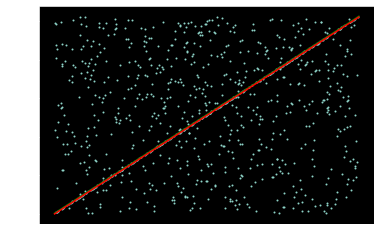

In [120]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data[:,0],data[:,1], s=1)
x = np.linspace(0, 1024, 4)
A, B, C = params['a'], params['b'], params['c']
ax.plot(x, (-A*x-C)/B, c='green')
A, B, C = detected_line
ax.plot(x, (-A*x-C)/B, c='red')